In [1]:
import numpy as np
import ringity as rng
import networkx as nx
import matplotlib.pyplot as plt

from collections import Counter

## Model parameters

In [59]:
N = 2**9


config_dict = {
    'default' : {
        'c' : 1,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'shorterResponse' : {
        'c' : 1,
        'r' : 0.125,
        'beta' : 1,
        'rho' : None,
    },
    'longerResponse' : {
        'c' : 1,
        'r' : 0.375,
        'beta' : 1,
        'rho' : None,
    },
    'weakerInteraction' : {
        'c' : 0.5,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'shorterDelay' : {
        'c' : 1,
        'r' : 0.25,
        'beta' : 0.75,
        'rho' : None,
    },
    'density' : {
        'c' : 0.5,
        'r' : None,
        'beta' : 1,
        'rho' : 0.25,
    }
}

In [100]:
configuration = 'weakerInteraction'

beta = config_dict[configuration]['beta']
r = config_dict[configuration]['r']
c = config_dict[configuration]['c']
rho = config_dict[configuration]['rho']

## Calculations

In [101]:
G, pos = rng.network_model(N=N, c=c, r=r, beta=beta, rho = rho, return_positions=True)

In [102]:
rate = rng.classes.network_model._get_rate_parameter(beta=beta, rate = None)

In [103]:
rho_obs = nx.density(G)
rho_exp = rng.interaction_strength_to_density(c=c, r=r, beta=beta)
score = rng.ring_score(G)

In [104]:
print(f"rho_obs = {rho_obs:.3f}")
print(f"rho_exp = {rho_exp:.3f}")
print(f"score   = {score:.3f}")

rho_obs = 0.126
rho_exp = 0.125
score   = 0.941


In [65]:
circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
spring_layout = nx.spring_layout(G)

## Interaction function

In [66]:
x = np.linspace(0, np.pi, 100)
y = c*(1-x/(2*np.pi*r)).clip(0)

fig_func, ax = plt.subplots(figsize = (8,5))

ax.plot(x, y, linewidth = 5)


plt.xticks([2*np.pi*r, np.pi], [r'$2\pi r$', r'$\pi$'])
plt.yticks([0, 0.5, 1, c], [r'$0$', r'$0.5$', r'$1$', r'$c$'])

ax.set_ylim(-0.025, 1.025)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

rng.ax_setup(ax)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

## Network visualization

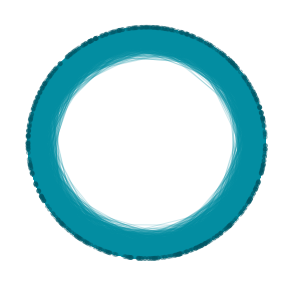

In [67]:
netviz_circ_fig, ax = plt.subplots(figsize = (5,5))

ax.set_xlim(-1.175,1.175)
ax.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax, pos = circ_layout)

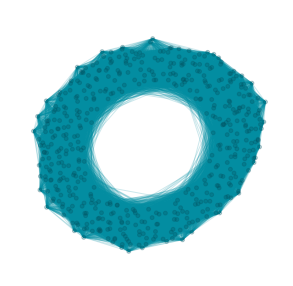

In [68]:
netviz_spri_fig, ax = plt.subplots(figsize = (5,5))

ax.set_xlim(-1.175,1.175)
ax.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax, pos = spring_layout)

## Clustering coefficient

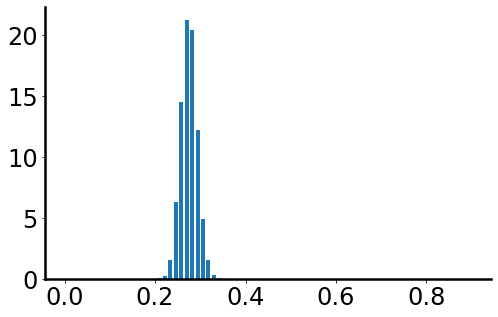

In [69]:
clust = []

for _ in range(2**5):
    G = rng.network_model(N=N, c=c, r=r, beta=beta)
    clust.extend(rng.clustering_coefficient(G))

clust_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=75, range=(0, 0.9), 
        rwidth = 0.75, density = True);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

rng.ax_setup(ax)

## Degree distribution

In [70]:
def expected_conditional_similarity(theta, rate, a):
    if np.isclose(rate, 0, atol=1e-7):
        return a
    
    if np.isclose(rate, np.inf):
        A = 1/(2*np.pi*a)
        B = A*np.pi
        C = B - 1
        return np.clip(np.abs(A*theta - B) - C, 0, 1)
    
    if theta < np.pi:
        if theta <= 2*np.pi*a:
            norm = 1 / (1 - np.exp(-2*np.pi*rate)) / (2*a*np.pi*rate)
            
            theta_term = -theta*rate * (1 - np.exp(-2*np.pi*rate))
            
            term1  = -2*np.exp(-rate*theta) + 1
            term21 =  np.exp(-rate*theta)*(np.exp(-2*a*np.pi*rate) + np.exp((2*a*np.pi - 2*np.pi)*rate))
            term22 = -np.exp(-2*np.pi*rate)
            
            return norm*(term1 + term21 + term22 + theta_term) + 1
        else:
            theta_term = np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
            alpha_term = (np.cosh(-rate*2*np.pi*a) - 1) / (a*np.pi*rate)
            return theta_term * alpha_term
        
    else:
        norm = 2*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
        
        def undef_int(t):
            return (np.exp(np.pi*rate)*(np.cosh((np.pi - t)*rate) + (-2*a*np.pi + t)*rate*np.sinh((np.pi - t)*rate)))/(2*a*np.pi*rate**2)
        
        if 2*np.pi - theta <= 2*np.pi*a:
            term1 = (-1 + np.cosh((2*np.pi - theta)*rate) + (2*(-1 + a)*np.pi + theta)*rate*np.sinh((2*np.pi - theta)*rate))/(2*a*np.pi*rate**2)
            term2 = undef_int(2*np.pi*a) - undef_int(2*np.pi - theta)
            return norm*term1 + norm*term2
        else:
            return norm*(np.sinh(a*np.pi*rate)**2)/(a*np.pi*rate**2)

In [71]:
degs_exp = [p for theta in pos for p in np.random.binomial(N-1, c*expected_conditional_similarity(theta=theta, rate=rate, a=r), size=2**10)]

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [72]:
degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

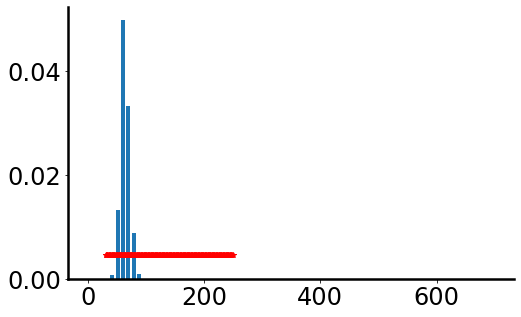

In [73]:
degs = []

for _ in range(2**3):
    G = rng.network_model(N=N, c=c, r=r, beta=beta)
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

deg_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 75, range = (0,700),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.set_xlabel('degree', fontsize=24)
#ax.set_ylabel('frequency', fontsize=18)

rng.ax_setup(ax)

## Save data

In [ ]:
fig_func.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_interactionFunction.png")
fig_func.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_interactionFunction.pdf")

netviz_circ_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_circular.png")
netviz_circ_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_circular.pdf")

netviz_spri_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_spring.png")
netviz_spri_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_spring.pdf")

clust_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_clustering.png")
clust_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_clustering.pdf")

deg_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_degree.png")
deg_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_degree.pdf")